<a href="https://colab.research.google.com/github/chungntu/1DCNN-LSTM-ResNet/blob/main/Problem16_Simply_supported_Timoshenko_problem%2C_under_uniform_load.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

min(w) = -1.5622538993888822  at x = 0.5
max(w) = 0.0  at x = 0.0


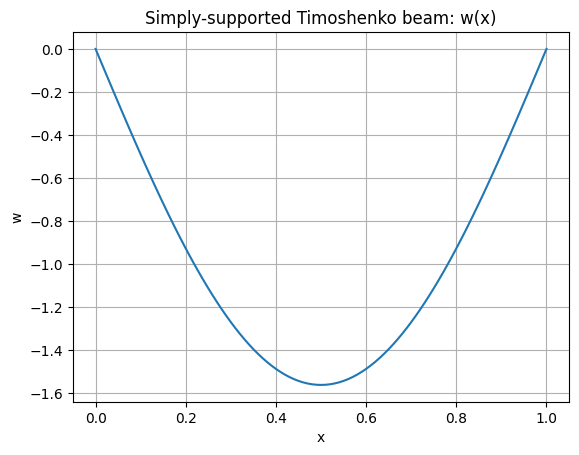

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# shapeFunctionL2: 2-node line element in natural coord xi [-1,1]
# ============================================================
def shapeFunctionL2(xi):
    N1 = 0.5 * (1.0 - xi)
    N2 = 0.5 * (1.0 + xi)
    shape = np.array([N1, N2], dtype=float)

    dN_dxi = np.array([-0.5, 0.5], dtype=float)
    return shape, dN_dxi


# ============================================================
# Timoshenko beam: assemble stiffness, force (and mass like MATLAB)
# DOF order:
#   w DOFs: 1..numberNodes
#   theta DOFs: numberNodes+1 .. 2*numberNodes
# elementDof = [indice, indice+numberNodes]  (MATLAB style)
# ============================================================
def formStiffnessMassTimoshenkoBeam(GDoF, numberElements,
                                   elementNodes, numberNodes, xx,
                                   C, P, rho, I, thickness):
    stiffness = np.zeros((GDoF, GDoF), dtype=float)
    mass = np.zeros((GDoF, GDoF), dtype=float)
    force = np.zeros((GDoF,), dtype=float)

    # -------------------------
    # Bending contribution (2-pt Gauss)
    # -------------------------
    gaussLocations = np.array([0.577350269189626, -0.577350269189626], dtype=float)
    gaussWeights = np.ones((2,), dtype=float)

    for e in range(numberElements):
        indice = elementNodes[e, :]               # 1-based node ids, length 2
        elementDof_1based = np.hstack([indice, indice + numberNodes])
        elementDof = elementDof_1based.astype(int) - 1  # to 0-based

        indice0 = indice.astype(int) - 1
        indiceMass = (indice + numberNodes).astype(int) - 1

        length_element = xx[indice0[1]] - xx[indice0[0]]
        detJ = length_element / 2.0
        invJ = 1.0 / detJ

        for q in range(len(gaussWeights)):
            xi = gaussLocations[q]
            wq = gaussWeights[q]

            shape, dN_dxi = shapeFunctionL2(xi)
            dN_dx = dN_dxi * invJ

            # B matrix (2 x 2*ndof), ndof=2
            B = np.zeros((2, 4), dtype=float)
            # MATLAB: B(1,ndof+1:2*ndof) = Xderivatives
            B[0, 2:4] = dN_dx

            # stiffness += B'B * wq*detJ * C(1,1)
            stiffness[np.ix_(elementDof, elementDof)] += (B.T @ B) * (wq * detJ * C[0, 0])

            # force on w DOFs: force(indice) += shape*P*detJ*wq
            force[indice0] += shape * P * detJ * wq

            # mass terms (same pattern as MATLAB screenshot)
            nn = np.outer(shape, shape) * (wq * detJ)
            mass[np.ix_(indiceMass, indiceMass)] += nn * (I * rho)
            mass[np.ix_(indice0, indice0)]       += nn * (thickness * rho)

    # -------------------------
    # Shear contribution (1-pt Gauss)
    # -------------------------
    gaussLocations = np.array([0.0], dtype=float)
    gaussWeights = np.array([2.0], dtype=float)

    for e in range(numberElements):
        indice = elementNodes[e, :]
        elementDof_1based = np.hstack([indice, indice + numberNodes])
        elementDof = elementDof_1based.astype(int) - 1

        indice0 = indice.astype(int) - 1
        length_element = xx[indice0[1]] - xx[indice0[0]]
        detJ = length_element / 2.0
        invJ = 1.0 / detJ

        for q in range(len(gaussWeights)):
            xi = gaussLocations[q]
            wq = gaussWeights[q]

            shape, dN_dxi = shapeFunctionL2(xi)
            dN_dx = dN_dxi * invJ

            B = np.zeros((2, 4), dtype=float)
            # MATLAB:
            # B(2,1:ndof) = Xderivatives
            # B(2,ndof+1:2*ndof) = shape
            B[1, 0:2] = dN_dx
            B[1, 2:4] = shape

            stiffness[np.ix_(elementDof, elementDof)] += (B.T @ B) * (wq * detJ * C[1, 1])

    return stiffness, force, mass


def solution(GDoF, prescribedDof_1based, stiffness, force):
    prescribed = np.array(prescribedDof_1based, dtype=int) - 1
    all_dofs = np.arange(GDoF)
    free = np.setdiff1d(all_dofs, prescribed)

    U = np.zeros((GDoF,), dtype=float)
    U[free] = np.linalg.solve(stiffness[np.ix_(free, free)], force[free])
    U[prescribed] = 0.0
    return U


# ============================================================
# MAIN: Simply-supported Timoshenko beam under uniform load
# ============================================================
E = 10e7
poisson = 0.30
L = 1.0
thickness = 0.001

I = thickness**3 / 12.0
EI = E * I
kapa = 5/6
P = -1.0

G = E / (2.0 * (1.0 + poisson))
C = np.array([[EI, 0.0],
              [0.0, kapa * thickness * G]], dtype=float)

numberElements = 100
xx = np.linspace(0.0, L, numberElements + 1)
numberNodes = len(xx)
GDoF = 2 * numberNodes

elementNodes = np.zeros((numberElements, 2), dtype=int)
for i in range(numberElements):
    elementNodes[i, 0] = i + 1
    elementNodes[i, 1] = i + 2

rho = 1.0  # not critical for static solve here
stiffness, force, mass = formStiffnessMassTimoshenkoBeam(
    GDoF, numberElements, elementNodes, numberNodes, xx, C, P, rho, I, thickness
)

# -------------------------
# Simply-supported BCs:
# w(0)=0 and w(L)=0, theta free
# -------------------------
fixedNodeW = np.array([1, numberNodes], dtype=int)     # 1-based node ids
fixedNodeTX = np.array([], dtype=int)                  # none

prescribedDof = np.hstack([fixedNodeW, fixedNodeTX + numberNodes]).tolist()

U = solution(GDoF, prescribedDof, stiffness, force)

w = U[:numberNodes]
theta = U[numberNodes:]

print("min(w) =", np.min(w), " at x =", xx[np.argmin(w)])
print("max(w) =", np.max(w), " at x =", xx[np.argmax(w)])

# plot
plt.figure()
plt.plot(xx, w)
plt.xlabel("x")
plt.ylabel("w")
plt.title("Simply-supported Timoshenko beam: w(x)")
plt.grid(True)
plt.show()
